In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel, ConstantKernel as C
from scipy.interpolate import interp1d
import os

%matplotlib inline

In [2]:
df_main = pd.read_csv('5501_analyzed_unc.csv', skiprows=1)
df_main.columns = [c.strip() for c in df_main.columns]

df_1 = pd.read_csv('5495_analyzed_unc.csv', skiprows=1)
df_2 = pd.read_csv('5501_analyzed_unc.csv', skiprows=1)
df_3 = pd.read_csv('5502_analyzed_unc.csv', skiprows=1)
df_4 = pd.read_csv('5507_analyzed_unc.csv', skiprows=1)
df_5 = pd.read_csv('5515_analyzed_unc.csv', skiprows=1)

df_high = pd.read_csv('5505_analyzed_unc.csv', skiprows=1)
df_high.columns = [c.strip() for c in df_high.columns]

In [3]:
common_strain = np.linspace(0, 0.25, 100)


def get_stress(df):
    df.columns = [c.strip() for c in df.columns] 
    f = interp1d(df['True Strain'], df['True Stress [MPa]'], fill_value="extrapolate")
    return f(common_strain)

# 2.  Type A (応力の重複度)
stresses = np.array([get_stress(df_1), get_stress(df_2), get_stress(df_3), get_stress(df_4), get_stress(df_5)])


# ddof=1サンプルの標準偏差
std_val = np.std(stresses, axis=0, ddof=1) 
# Type A = 标准差 / 根号N　ここのσの感度係数は１になる
u_type_a = std_val / np.sqrt(5)
print(u_type_a)

# 3.  Type B (温度の影響)
#  Master List より温度の誤差は±5
u_temp_limit = 5.0 
u_temp_std = u_temp_limit / np.sqrt(3) # 矩形分布

# 温度の感度係数Ct = (高温における応力- 「常温」における応力) / 音叉
stress_20 = get_stress(df_main)
stress_120 = get_stress(df_high)
c_temp = (stress_120 - stress_20) / (120 - 20)

# Type B  温度の感度係数 * 温度の不確かさ
u_type_b = np.abs(c_temp * u_temp_std)
print(u_type_b)

# 4. 合成不確かさ
u_total = np.sqrt(u_type_a**2 + u_type_b**2)
print(u_total)

[25.69289377 22.87369536 20.1034622  17.40558958 14.81964941 12.41577916
 10.32197845  8.7633903   8.0568532   8.41967108  9.73298219 10.45326868
  9.30051022  8.42734929  7.85822568  7.11119784  5.8346207   6.66614141
  5.90814557  7.04876531  7.13964709  7.52512023  6.55060201  8.08804299
  8.54511528  7.63805749  7.23291514  6.4334289   5.19991398  6.19267797
  6.39354024  4.90103455  4.70875127  5.47010262  6.04439364  5.30325757
  6.01664289  6.44332614  5.53969225  6.2708556   5.21688089  5.73033405
  5.77343591  5.56970772  5.77299504  5.75849688  5.18243361  4.9217608
  5.64595104  5.52061126  5.44280944  5.54476456  4.89976218  5.14448381
  5.84331506  5.4548495   5.70355257  6.26347638  5.71303342  5.53606182
  5.16510659  6.03135631  5.41596018  4.8352918   5.21713698  4.61834674
  5.1511635   4.82387821  4.20937372  4.41218288  4.37009341  5.10432462
  5.05872163  4.69257098  4.74728602  4.85678377  3.71571884  4.75166075
  5.04413152  5.097451    6.28510376  5.20720865  3.

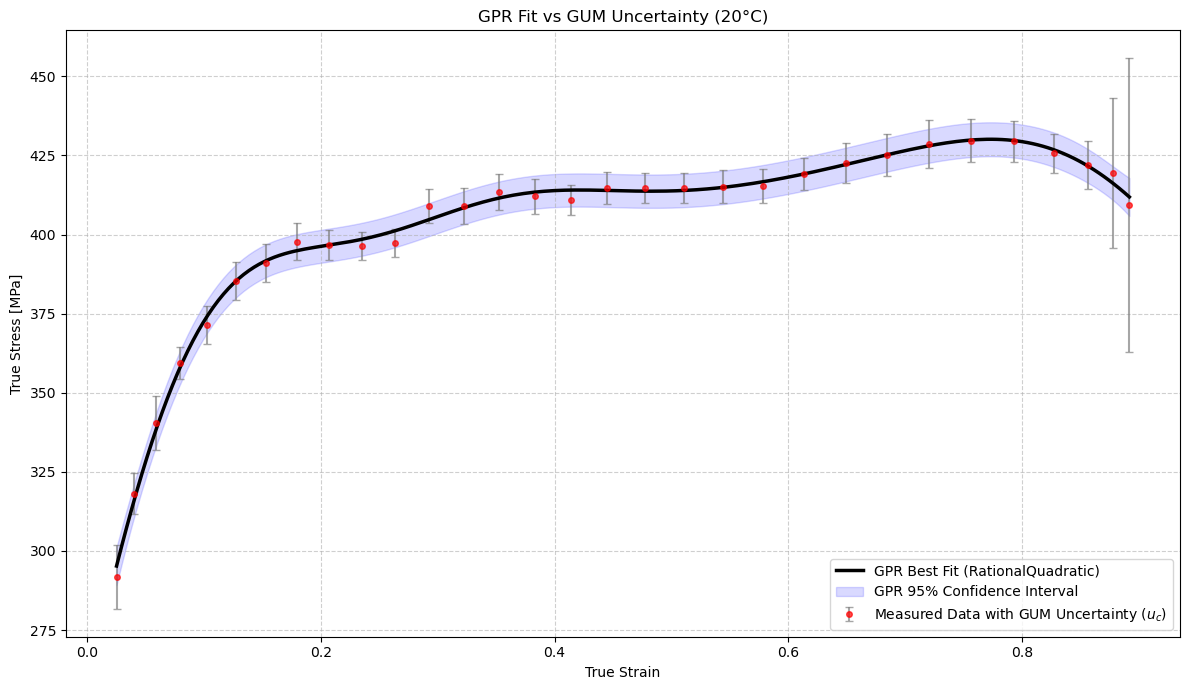

In [6]:
def load_csv_safe(fname):
    if os.path.exists(fname):
        try:
            df = pd.read_csv(fname, skiprows=1)
            df.columns = [c.strip() for c in df.columns]
            return df
        except: return None
    return None

df_20 = load_csv_safe('5501_analyzed_unc.csv')
df_120 = load_csv_safe('5505_analyzed_unc.csv')

files_rep = ['5495_analyzed_unc.csv', '5501_analyzed_unc.csv', '5502_analyzed_unc.csv', '5507_analyzed_unc.csv', '5515_analyzed_unc.csv']
dfs_rep = [load_csv_safe(f) for f in files_rep if load_csv_safe(f) is not None]


df_sub = df_20.iloc[::10]

X_train = df_sub['True Strain'].values.reshape(-1, 1)
y_train = df_sub['True Stress [MPa]'].values

target_strains = df_sub['True Strain'].values


def get_interp(df):
    f = interp1d(df['True Strain'], df['True Stress [MPa]'], fill_value="extrapolate")
    return f(target_strains)

#  Type A (重复性) 
if len(dfs_rep) > 1:
    stresses_rep = np.array([get_interp(df) for df in dfs_rep])
    u_type_a = np.std(stresses_rep, axis=0, ddof=1) / np.sqrt(len(dfs_rep))
else:
    u_type_a = np.zeros_like(target_strains)

# Type B 
if df_120 is not None:
    s_20 = get_interp(df_20)
    s_120 = get_interp(df_120)
    c_temp = (s_120 - s_20) / (120 - 20)
    u_temp_std = 5.0 / np.sqrt(3)
    u_type_b = np.abs(c_temp * u_temp_std)
else:
    u_type_b = np.zeros_like(target_strains)


u_gum_total = np.sqrt(u_type_a**2 + u_type_b**2)


# GPR 

kernel = C(1.0) * RationalQuadratic(length_scale=0.5, alpha=1.0) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=10, random_state=42)

gpr.fit(X_train, y_train)


X_pred = np.linspace(X_train.min(), X_train.max(), 200).reshape(-1, 1)
y_pred, y_std = gpr.predict(X_pred, return_std=True)


plt.figure(figsize=(12, 7))

# GUM結果を足す
plt.errorbar(X_train.ravel(), y_train, yerr=u_gum_total, 
             fmt='ro', markersize=4, ecolor='gray', elinewidth=1.5, capsize=3, alpha=0.7, 
             label='Measured Data with GUM Uncertainty ($u_c$)')

plt.plot(X_pred, y_pred, 'k-', linewidth=2.5, label='GPR Best Fit (RationalQuadratic)')


plt.fill_between(X_pred.ravel(), 
                 y_pred - 1.96 * y_std, 
                 y_pred + 1.96 * y_std, 
                 color='blue', alpha=0.15, label='GPR 95% Confidence Interval')

plt.title('GPR Fit vs GUM Uncertainty (20°C)')
plt.xlabel('True Strain')
plt.ylabel('True Stress [MPa]')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()